### 1. Import proper libraries

In [1]:
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics

import tensorflow as tf
tf.random.set_seed(101)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### 2. Import datasets

In [2]:
try:
    test = pd.read_csv('datasets/exoTest.csv').fillna(0)
    train = pd.read_csv('datasets/exoTrain.csv').fillna(0)
except:
    test = pd.read_csv('https://www.dropbox.com/s/6buiect8icf4bs1/exoTest.csv?dl=0')
    train = pd.read_csv('https://www.dropbox.com/s/sbk5n4azwfarc95/exoTrain.csv?dl=0')

In [3]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


### 3. Perform EDA review

In [4]:
test.shape

(570, 3198)

In [5]:
train.shape

(5087, 3198)

In [6]:
train.isnull().sum().sum()

0

In [7]:
train['LABEL'].value_counts() #Review predictor varaiable Y

1    5050
2      37
Name: LABEL, dtype: int64

### `Label` column, our predictor column y-variable, is in terms of `1`'s and `2`'s. 
### Change to standard `0`'s and `1`'s:

In [8]:
train['LABEL'].replace({2 : 1 ,
                        1 : 0 }, inplace=True)

In [9]:
train['LABEL'].value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

### Memory reduction function

In [10]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe before optimization: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe after optimization : {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
train = reduce_memory(train)
test = reduce_memory(test)

Memory usage of dataframe before optimization: 124.12 MB
Memory usage of dataframe after optimization : 62.04 MB
Decreased by 50.0%
Memory usage of dataframe before optimization: 13.91 MB
Memory usage of dataframe after optimization : 6.25 MB
Decreased by 55.1%


### 4. Split the data

In [12]:
X_train = train.drop(["LABEL"], axis=1)
y_train = train['LABEL']

X_test = test.drop(["LABEL"], axis=1)
y_test = test["LABEL"]

In [13]:
X_train.head(1)

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.849998,83.809998,20.1,-26.98,-39.560001,-124.709999,-135.179993,-96.269997,-79.889999,-160.169998,...,-78.07,-102.150002,-102.150002,25.129999,48.57,92.540001,39.32,61.419998,5.08,-39.540001


### 5. Normalizing the data

In [14]:
X_train = normalize(X_train)
X_test = normalize(X_test)

### 6. Applying a gaussian filter

In [15]:
X_train = ndimage.filters.gaussian_filter(X_train, sigma=10)
X_test = ndimage.filters.gaussian_filter(X_test, sigma=10)

### 7. Feature Scaling

In [16]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### 8. Dimensionality Reduction

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train_sc)
X_test = pca.transform(X_test_sc)

total = sum(pca.explained_variance_)
k = 0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k += 1

In [18]:
k #Value will give us total number of features w/97% explained variance

37

In [19]:
pca = PCA(n_components = k )

### Apply PCA w/ n_components: k = 37

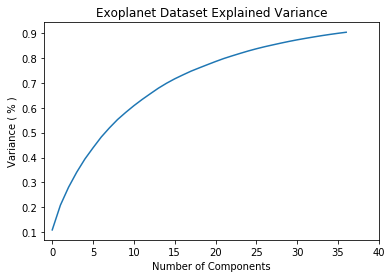

In [20]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(-1,40)
plt.xlabel("Number of Components")
plt.ylabel("Variance ( % )")
plt.title("Exoplanet Dataset Explained Variance")
plt.show();

In [21]:
X_train.shape

(5087, 37)

In [22]:
X_test.shape

(570, 37)

### 9. Correct for imbalance in the data

In [23]:
#Resampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before Oversampling, counts of label '0': {}\n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 37
Before Oversampling, counts of label '0': 5050



In [24]:
sm = SMOTE(random_state=27,
           ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())


In [25]:
y_train_res.shape

(10100,)

In [26]:
X_train_res.shape

(10100, 37)

### 10. Network Topology

In [27]:
def model_func(layer_one_neurons=4, layer_two_neurons=4):
    model = Sequential()
    model.add(Dense(layer_one_neurons, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_res.shape[1]))
    model.add(Dense(layer_two_neurons, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units=1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return model

In [28]:
### Run the model
model = KerasClassifier(build_fn = model_func, epochs = 40)
accuracies = cross_val_score(estimator = model,
                             X = X_train_res,
                             y = y_train_res,
                             cv=5,
                             n_jobs=-1)

mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+str(mean))
print("Accuracy variance: "+str(variance))

Accuracy mean: 0.8850495100021363
Accuracy variance: 0.12448241938320354


### 11. Build a GridSearch

In [29]:
def model_func(layer_one_neurons,
               layer_two_neurons,
               layer_three_neurons,
               layer_four_neurons):
    
    model = Sequential()
    model.add(Dense(layer_one_neurons, kernel_initializer = 'uniform', activation = 'relu',input_dim = X_train_res.shape[1]))
    model.add(Dense(layer_two_neurons, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(layer_three_neurons, kernel_initializer = 'uniform', activation = 'relu'))
    
    model.add(Dense(units=1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return model

nn = KerasClassifier(build_fn=model_func, batch_size=512, verbose=0)

params = {
    'layer_one_neurons' : [32, 64, 128, 256],
    'layer_two_neurons' : [32, 64, 128, 256],
    'layer_three_neurons' : [32, 64, 128, 256],
    'layer_four_neurons' : [32,64,128],
    # 'layer_one_dropout' : [0,.1,.2],
    'epochs' : [50],
    'batch_size' : [512],
    }

gs = GridSearchCV(nn, param_grid=params, cv=4)
gs.fit(X_train_res, y_train_res)

gs.best_params_

accuracies = cross_val_score(estimator = model,
                             X = X_train_res,
                             y = y_train_res,
                             cv=5,
                             n_jobs=-1)

mean = accuracies.mean()
variance = accuracies.std()
underline = lambda text: '\033[4m' + text + '\033[0m'
print(underline("Keras Classifier using GridSearch\n"))
print("-Accuracy mean----| "+str(    round(mean,5)    ))
print("-Accuracy variance| "+str(    round(variance,5)))

print("\nGrid Search Best Score: "+str(   round(gs.best_score_),5))


Keras Classifier using GridSearch

-Accuracy mean----| 0.88545
-Accuracy variance| 0.09627


TypeError: str() argument 2 must be str, not int

    Keras Classifier using GridSearch

    -Accuracy mean----| 0.91069
    -Accuracy variance| 0.09828

    Grid Search Best Score: 0.9941584169864655

    -Previous
    Keras Classifier using GridSearch
    -Accuracy mean----| 0.9084158539772034
    -Accuracy variance| 0.09503712221162734

    -Previous
    Keras Classifier using GridSearch
    -Accuracy mean: 0.9014851450920105
    -Accuracy variance: 0.08062288439072052

    -Previous
    -Grid Search Best Score: 0.7488118708133698
    -Accuracy mean: 0.8769306898117065
    -Accuracy variance: 0.12128029578467514

    -Previous
    -Grid Search Best Score: 0.7726732492446899
    -Accuracy mean: 0.826930683851242
    -Accuracy variance: 0.196483547742121